# Статистика, прикладной поток
## Практическое задание 5

В данном задании вы исследуете некоторые свойства непараметрических методов, а также проверки статистических гипотез.

**Правила:**

* Дедлайн **1 декабря 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[S19] Фамилия Имя - задание 5"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `5.N.ipynb` и `5.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него. Правила оформления смотрите в презентации с первого практического занятия.
* При решении без доказательства можно пользоваться любыми теоретическими свойствами, которые были на лекциях или семинарах.
* Разделяйте код вычислений и отрисовки графиков. Так будет удобнее вам и проверяющим.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  2 балла **O3**
* Задача 2 -  10 баллов **O2**
* Задача 3 -  5 баллов **O3**
* Задача 4 -  5 баллов **O3**
* Задача 5 -  5 баллов **O3**
* Задача 6 - 12 баллов **O3**
* Задача 7 - 20 баллов **O3**
* Задача 8 - 20 баллов **O3**

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
import warnings
import pandas as pd
from statsmodels.nonparametric.kde import kernel_switch, KDEUnivariate
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Непараметрический подход

__________________
### Задача 1.

Напишите определение ядра, используемого для построения ядерных оценок плотности.

Пусть $X = (X_1, ..., X_n)$ - выборка из непрерывного распределения.

Выберем:
- $q(x)$ - ядро (некоторая симметричная плотность, которую рассматриваем за базовую)
- $h > 0$ - ширина ядра (отвечает за масштабирование)

Ядерная оценка плотности:
$$
\widehat{p}_h(x) = \frac{1}{n\cdot h} \sum\limits_{i=1}^{n}q\left(\frac{x - X_i}{h}\right)
$$

Прежде чем начать работу с ядерными оценками плотности, изучим виды ядер. В библиотеке `statsmodels` реализованы следующие ядра:

In [2]:
list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']

Нарисуем эти ядра. Запустите код в ячейке.

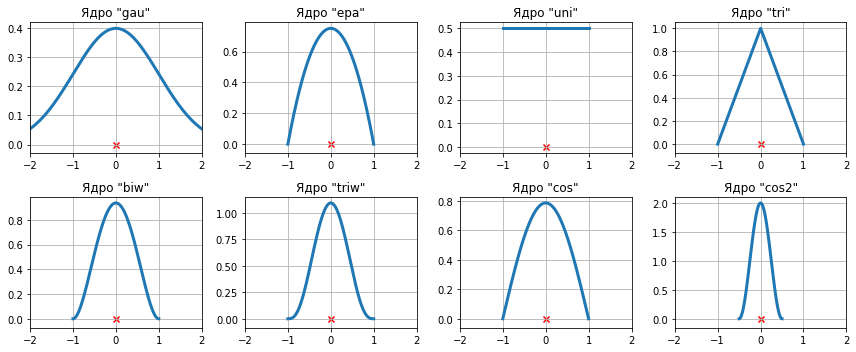

In [3]:
fig = plt.figure(figsize=(12, 5))

for i, (ker_name, ker_class) in enumerate(kernel_switch.items()):
    kernel = ker_class()  # ядро
    domain = kernel.domain or [-2, 2]  # носитель
    x_vals = np.linspace(*domain, 2**10)
    y_vals = kernel(x_vals)

    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Ядро "{}"'.format(ker_name))
    ax.plot(x_vals, y_vals, lw=3, label='{}'.format(ker_name))
    ax.scatter([0], [0], marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim((-2, 2))
    
plt.tight_layout()

Посмотрим, как будет выглядеть ядерная оценка плотности в зависимости от типа ядра, взяв в качестве реализации выборки набор точек [-1, 0, 1]. Запустите код в ячейке.

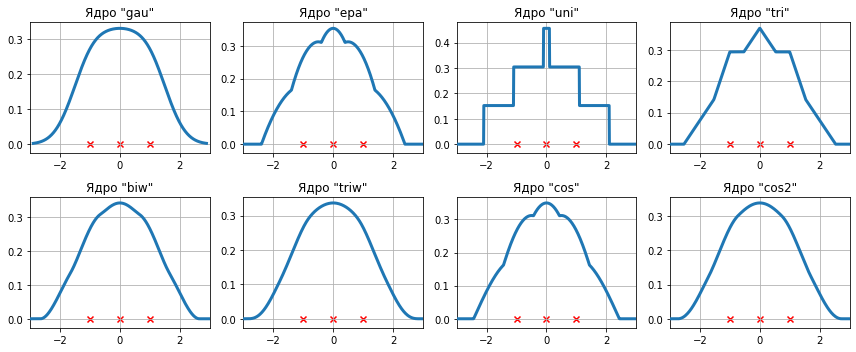

In [4]:
data = np.linspace(-1, 1, 3)  # выборка
kde = KDEUnivariate(data)  # объект, выполняющий построение оценки

fig = plt.figure(figsize=(12, 5))

for i, kernel in enumerate(kernel_switch.keys()):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Ядро "{}"'.format(kernel))
    
    # построение ядерной оценки плотности с заданным ядром
    kde.fit(kernel=kernel, fft=False, gridsize=2**10)
    # отрисовка полученной оценки
    ax.plot(kde.support, kde.density, lw=3, zorder=10)
    # отрисовка выборки
    ax.scatter(data, np.zeros_like(data), marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim([-3, 3])
    
plt.tight_layout()

Какие вы можете назвать преимущества и недостатки для первых трех ядер как с точки зрения самой оценки плотности, так и с вычислительной точки зрения?

Преимущества:
- gau: наиболее гладкое из первых трех
- epa: сильно возрастает в точках, соответствующих элементам выборки
- uni: наиболее просто вычисляется (т.к. изначально const функция), наиболее понятно выглядит

Недостатки:
- gau: из-за экспоненты тяжело вычислимо
- uni: разрывное, при этом даже для выборке, о которой нельзя точно сказать, что 0 самое часто встречаемое, плотность в нуле сильно больше, чем в других точках.

Другие примеры работы с ядерными оценками плотности можно посмотреть по ссылке http://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html

__________________
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики $$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле? 

Для выполнения задания можно использовать следующую функцию:

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
# help(ECDF)  # В случае затруднений раскомментировать и выполнить

In [6]:
def Fn(x, sample):
    return np.array([ECDF(sample[:i+1])(x) for i in range(len(sample))])

def diff_F_Fn(x, sample):
    return np.abs(Fn(x, sample) - sps.norm.cdf(x))

def Dn(sample):
    diff = diff_F_Fn(np.linspace(-2, 2, 1000), sample)
    return diff.max(axis=1) #т.к. по сути получится матрица

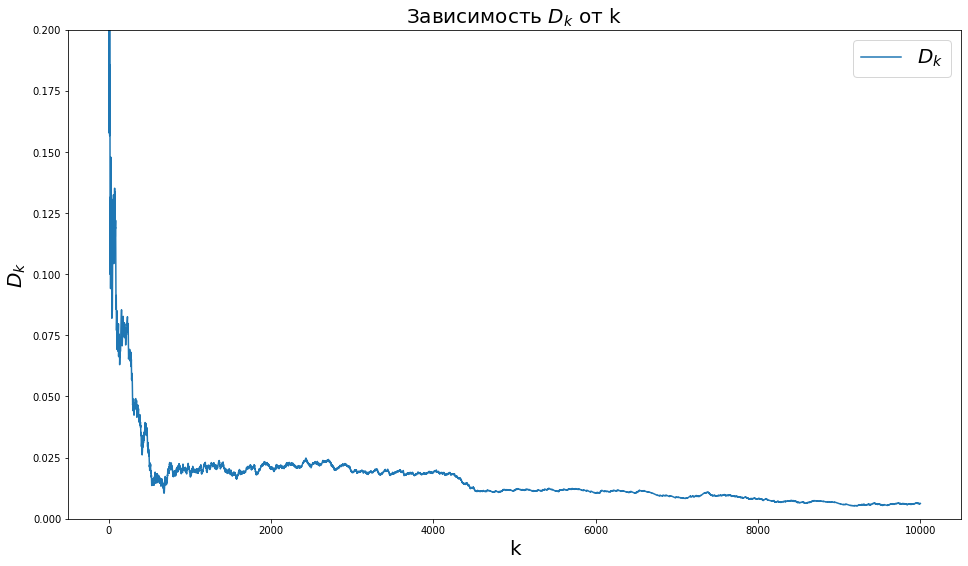

In [7]:
n = 10**4
sample = sps.norm().rvs(n)
x = np.linspace(1, n, n)

plt.figure(figsize=(16, 9))
plt.plot(x, Dn(sample), label = r"$D_k$")

plt.title(r"Зависимость $D_k$ от k", fontsize=20)
plt.ylim((0, 0.2))
plt.xlabel("k", fontsize=20)
plt.ylabel(r"$D_k$", fontsize=20)
plt.legend(fontsize=20)
plt.show()

**Вывод:** График полностью соответствует теореме Гливенко-Кантелли. Мы видим, что $D_k$ равномерно сходится к $0$ при $k \rightarrow \infty$. Из этого ясно, что эмпирическая функция с ростом k хорошо приближает истинную.

**2.** Для $n = 10000$ и $k = 10000$ (значение $k$ можно взять больше) выполните следующее:
    
Вычислите $D_n^1, ... , D_n^k$ для независимых выборок $(X_1^1, ... , X_n^1)$, ... ,$(X_1^k, ... , X_n^k)$ из стандартного нормального распределения. Постройте график гистограммы значений $\sqrt{n} D_n^1, ... , \sqrt{n} D_n^k$ и ядерной оценки плотности распределения этих величин.

Для выполнения задания можно воспользоваться как функцией `seaborn.distplot` (желательно), так и реализацией в `statsmodels`.

In [8]:
def Fn_0(x, sample):
    return np.array([ECDF(T.flatten())(x) for T in sample])

def diff_F_Fn_0(x, sample):
    return np.abs(Fn_0(x, sample) - sps.norm.cdf(x))

def Dn_0(sample):
    diff = diff_F_Fn_0(np.linspace(-2, 2, 1000), sample)
    return diff.max(axis=1) #т.к. по сути получится матрица

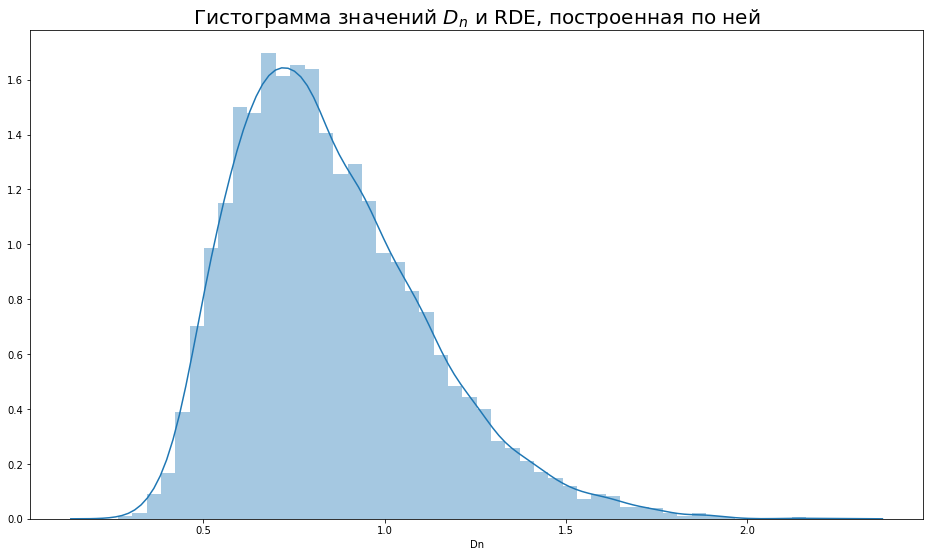

In [9]:
n = 10000
k = 10000

sample = sps.norm().rvs((k, n))
D = Dn_0(sample)

plt.figure(figsize=(16, 9))
sns.distplot(np.sqrt(n) * D)

plt.title("Гистограмма значений $D_n$ и RDE, построенная по ней", fontsize=20)
plt.xlabel("Dn")
plt.show()

**Вывод:** Наше распределение напоминает распределение Колмогорова. Тем самым, наш результат подтверждает теорему Колмогорова, о том, что $\sqrt(n) \cdot D_n$ сходится по распределению к случайной величине, имеющей распределение Колмогорова.

__________________
### Задача 3.
Для каждого распределения постройте график эмпирической функции распределения, гистограмму и график ядерной оценки плотности. 

Вам выдается почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [10]:
def draw_ecdf(sample, grid, cdf=None):
    """По сетке grid cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.scatter(sample[:size], np.zeros(size),
                    alpha=0.4, label='sample')
        
        if cdf is not None:
            plt.plot(grid,
                     cdf(grid),
                     color='green', alpha=0.3, lw=2, label='true cdf')
        
        plt.plot(grid,
                 ECDF(sample[:size])(grid), 
                 color='red', label='ecdf')
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

In [11]:
def draw_hist(sample, grid, pdf=None):
    """Строит гистограмму и, по сетке grid, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.hist(sample[:size], 
                 bins=20,
                 range=(grid.min(), grid.max()),
                 density=True, label='sample hist')
        
        if pdf is not None:
            plt.plot(grid,
                     pdf(grid),
                     color='green', alpha=0.3, lw=2, label='true pdf')
        
        plt.legend()
    plt.show()

In [18]:
def draw_pdf(sample, grid, pdf=None):
    """По сетке grid cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки
    и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.scatter(sample[:size], np.zeros(size),
                    alpha=0.4, label='sample')
        
        if pdf is not None:
            plt.plot(grid,
                     pdf(grid), color='green', 
                     alpha=0.3, lw=2, label='true pdf')
        
        kde = KDEUnivariate(sample[:size])
        kde.fit()
        plt.plot(grid,
                 kde.evaluate(grid),
                 color='red', label='kde')
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Теперь примените реализованные выше функции к выборкам размера 500 для следующих распределений:

In [19]:
n = 500

*1. Равномерное распределение $U[0,1]$*. Графики (ф.р., плотностей) строить на интервале $(-0.2, 1.2)$.

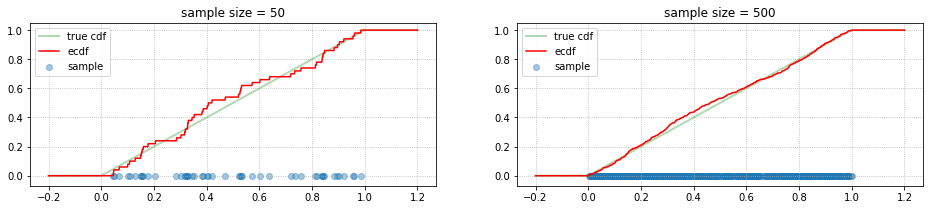

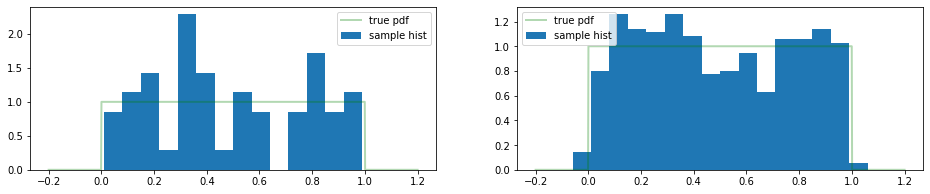

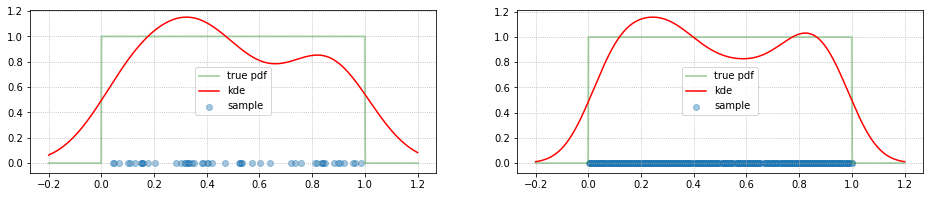

In [20]:
sample = sps.uniform().rvs(n)
grid = np.linspace(-0.2, 1.2, 1000)

draw_ecdf(sample, grid, sps.uniform().cdf)
draw_hist(sample, grid, sps.uniform().pdf)
draw_pdf(sample, grid, sps.uniform().pdf)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики строить на интервале $(-3, 3)$.

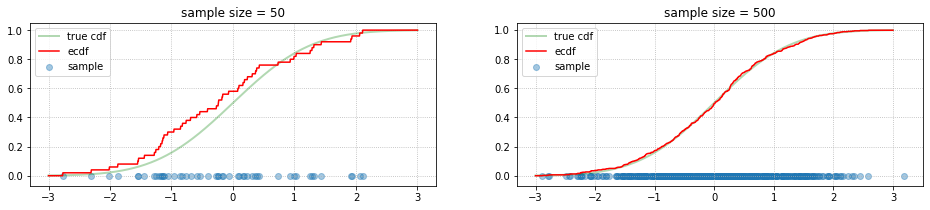

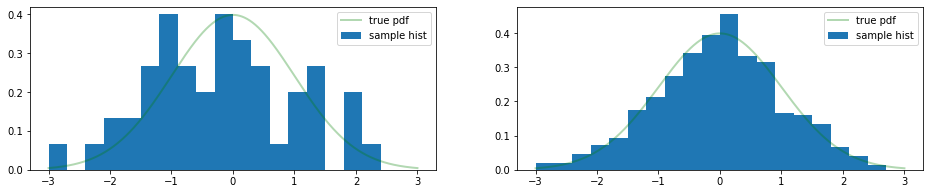

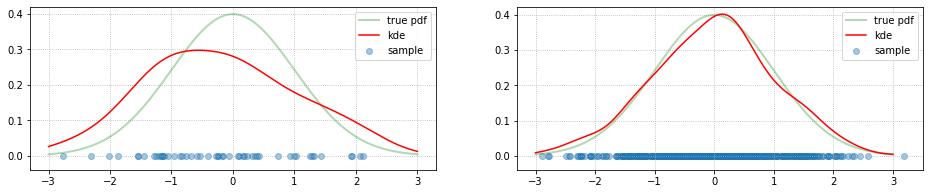

In [15]:
sample = sps.norm().rvs(n)
grid = np.linspace(-3, 3, 1000)

draw_ecdf(sample, grid, sps.norm().cdf)
draw_hist(sample, grid, sps.norm().pdf)
draw_pdf(sample, grid, sps.norm().pdf)

*3. Экспоненциальное распределение $Exp(1)$.* Графики строить на интервале $(-0.5, 5)$.

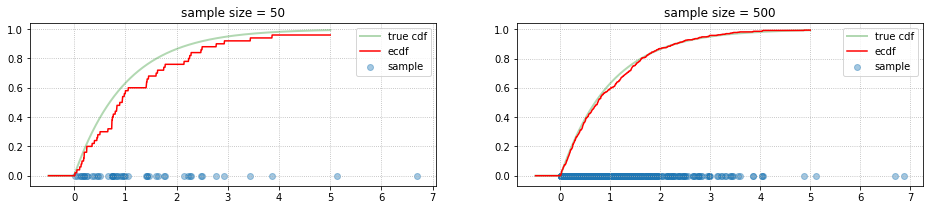

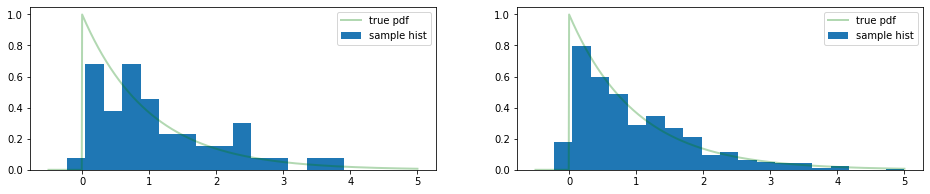

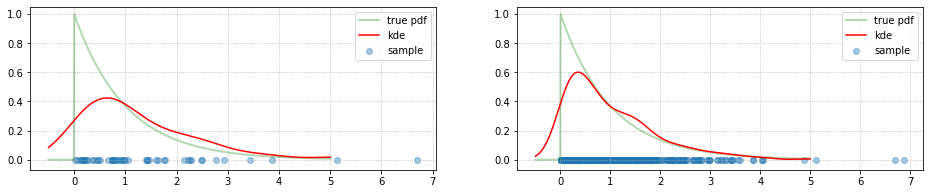

In [16]:
sample = sps.expon().rvs(n)
grid = np.linspace(-0.5, 5, 1000)

draw_ecdf(sample, grid, sps.expon().cdf)
draw_hist(sample, grid, sps.expon().pdf)
draw_pdf(sample, grid, sps.expon().pdf)

**Вывод:** даже при небольших размерах выборки (50), график эмпирической ф.р. и ядерной оценки плотноти уже становятся похожими на истинные графики. Но при этом, гистограмма все-таки достаточно плохо приближает - все-таки 50 элементов для построения гистограммы, похожей на истинную плотность, мало. При выборки из 500 элементов графики нормального распределения уже почти сливаются с истинными (оно понятно, т.к. ядро выбрано гауссово, и ядерная оценка плотности близка поэтому). При это в экспоненциальном и равномерном тоже все хорошо, кроме графиков ядерной оценки плотности, но и они достаточно стараются приблизить истинную.

__________________
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [23]:
size = 200
sample = sps.uniform().rvs(size)
grid = np.linspace(-0.2, 1.2, 500)

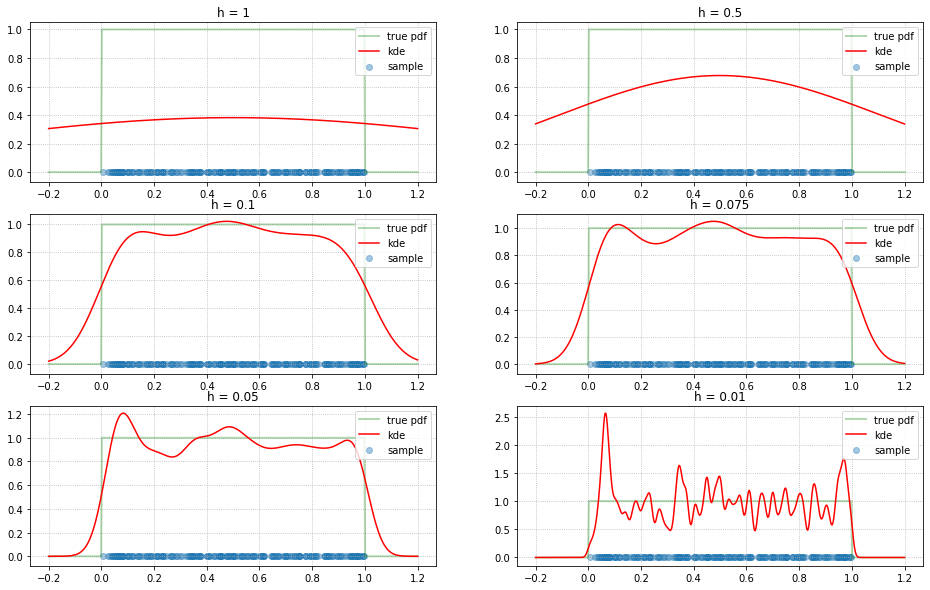

In [35]:
plt.figure(figsize=(16, 10))
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(bw=bw)
    
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='sample')
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='true pdf')
    plt.plot(grid, kernel_density.evaluate(grid), 
             color='red', label='kde')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

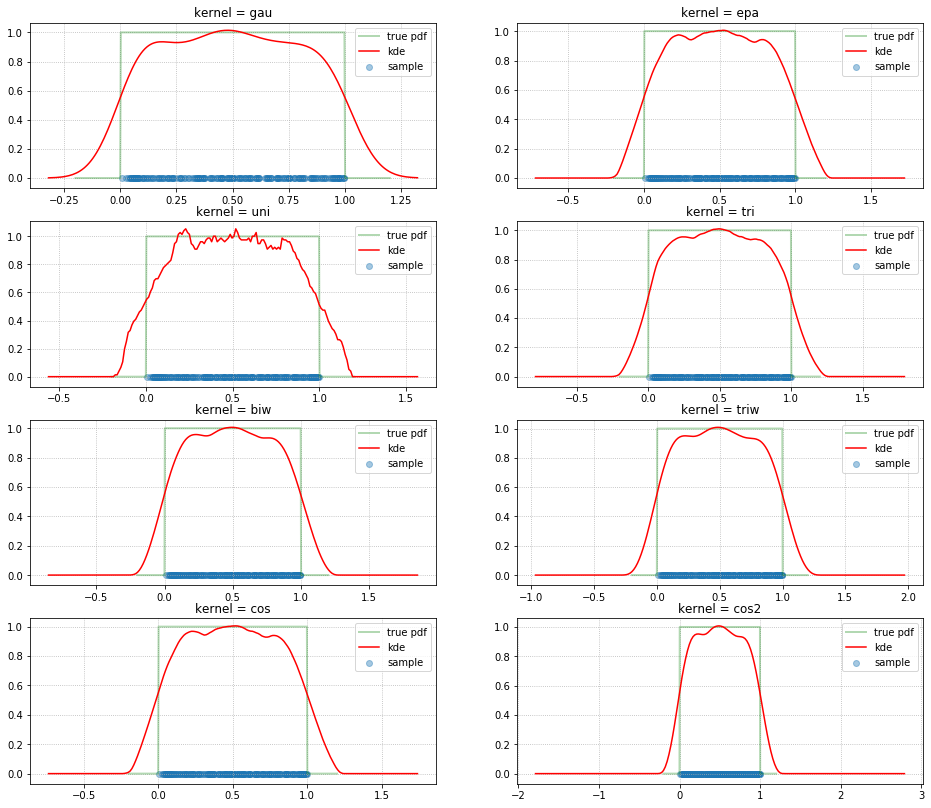

In [32]:
plt.figure(figsize=(16, 14))
for i, kernel in enumerate(kernel_switch.keys()):
    plt.subplot(4, 2, i + 1)
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(kernel=kernel, fft=False)
    
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='sample')
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='true pdf')
    plt.plot(kernel_density.support, kernel_density.density, 
             color='red', label='kde')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('kernel = {}'.format(kernel))
plt.show()

**Вывод:** Из вторых графиков видно, что KDE при размере выборке 200 не сильно зависит от выбранного нами ядра: все они приближают примерно одинаково, совпадая с истиной плотности в $x = 0.5$, и ошибаясь на краях.

При этом, на первых графиках видно, что при плохо подобранном размере ширины ядра наша KDE может очень сильно отличаться от выбранной плотности: чем меньше ширина, тем менее гладкой становится картинка. Понятно, что график идеальной гладкости - почти прямая (немного искривленная), но прямая очень плохо приближает искомую плотность, а негладкий график - огромное количество сильных перепадов KDE.

__________________
### Задача 5.

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine"> wine dataset </a> и выберите произвольные 3 произвольных
столбца с действительными числами, а также столбцы `Total phenols` и `Alcohol`. 

С помощью `seaborn.PairGrid` постройте таблицу графиков,
состоящую из
* одномерных ядерных оценок плотности по диагонали;
* двумерных ядерных оценок плотности ниже диагонали;
* scatter-plot выше диагонали (`plt.scatter`)


При возникновении затруднений посмотрите обучающий ноутбук по seaborn .

In [43]:
wine = pd.read_csv("wine.data")[["Total phenols",
                                "Alcohol",
                                "Magnesium",
                                "Ash",
                                "Flavanoids"]
wine.head()

Total phenols  Alcohol  Magnesium   Ash  Flavanoids
1           2.80    14.23        127  2.43        3.06
1           2.65    13.20        100  2.14        2.76
1           2.80    13.16        101  2.67        3.24
1           3.85    14.37        113  2.50        3.49
1           2.80    13.24        118  2.87        2.69

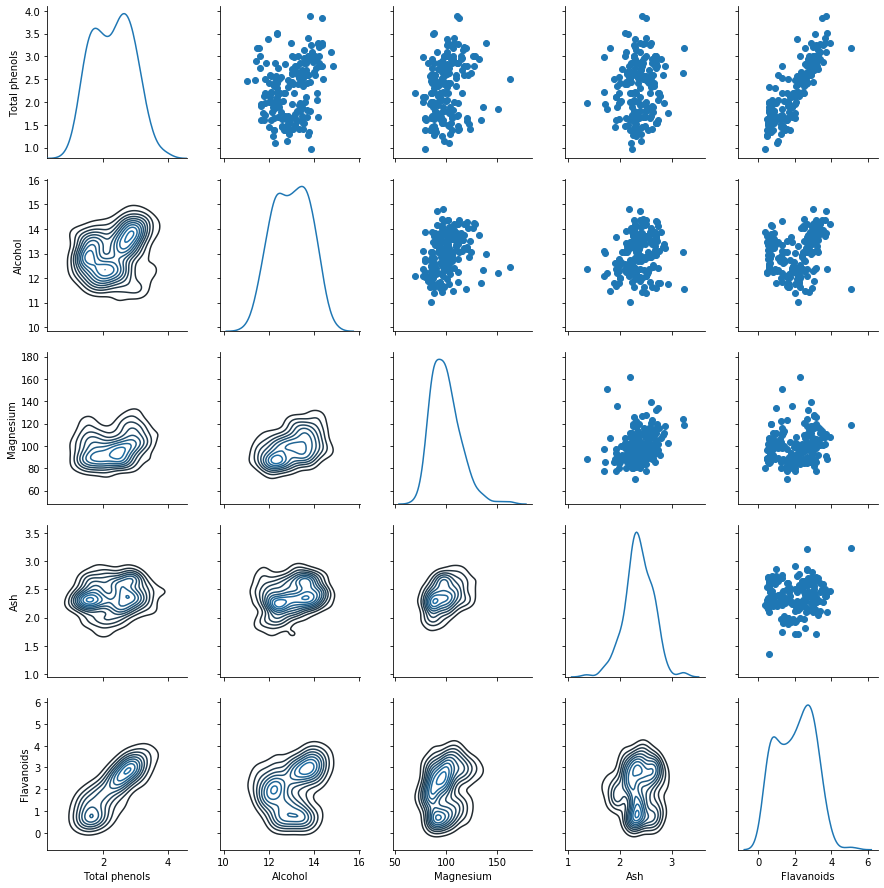

In [51]:
g = sns.PairGrid(wine, diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)

Какие графики более наглядны: ядерные оценки плотности или scatter plots? 


Что можно сказать про распределения значений величин? С чем это может быть связано? (обратите внимание на пики)

Как не странно, мне более наглядными показались scatter plots, т.к. они точечные, и глазом легче отслеживать выбросы, например. При этом ядерные оценки плотности дают хорошее общее представление о зависимости признаков, и если показывать на какой-то презентации, то лучше использовать их.

Посмотрим на главную диагональ:
- Равномерное напоминают Alcogol, Flavanoid, Total Phenols
- Нормальное - Ash
- Экспоненциальное - Magnesium

Пока что мы строили графики для значений признаков вин вне зависимости от их сорта (колонка `Class`). 
Это нужно для того, чтобы найти основные свойства распределения: какие значения оно принимает чаще всего, сколько пиковых значений у оценки плотности, насколько велик разброс значений и тд. 

Однако сейчас мы не знаем, как влияет сорт вина на значения признаков и стоит ли им пренебрегать.
Проведем небольшое иследование

Постройте графики одномерных оценок плотности для выбранных признаков, которые нарисуйте в два столбца.

В каждой строке:

* На первом графике нарисуйте три оценки плотности признака для вин каждого типа.

* На втором графике нарисуйте график ядерной оценки плотности для всех значений признака, которые есть в датасете (то есть независимо от типа вина)


In [86]:
wine = pd.read_csv("wine.data")[["Total phenols",
                                "Alcohol",
                                "Magnesium",
                                "Ash",
                                "Flavanoids"]]
wine = wine.astype({'Magnesium': "float64"})
names = ["Total phenols",
         "Alcohol",
         "Magnesium",
         "Ash",
         "Flavanoids"]

wines = [wine[wine.index == i] for i in range(1, 4)]

In [94]:
def plot_KDE(sample, grid, color='red', label=''):
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(kernel="gau")
    plt.plot(grid, kernel_density.evaluate(grid), 
             color=color, label='kde ' + label)
    

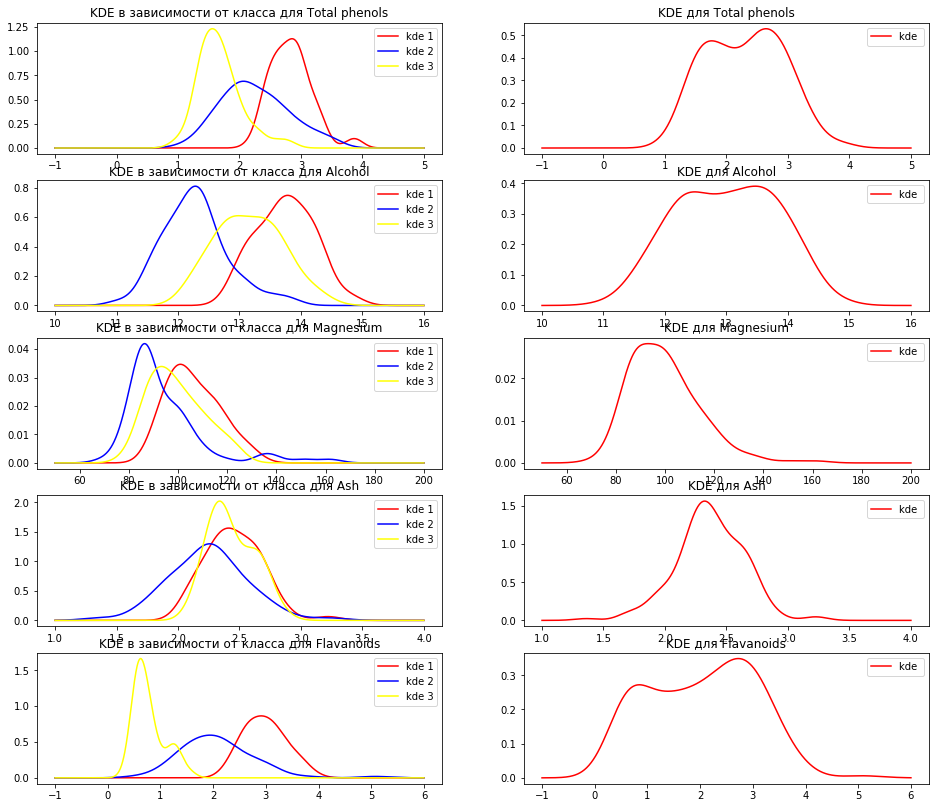

In [97]:
plt.figure(figsize=(16, 14))
limits = [[-1, 5],
          [10, 16],
          [50, 200],
          [1, 4],
          [-1, 6]]
for i in range(5):
    grid = np.linspace(*limits[i], 1000)
    
    plt.subplot(5, 2, 2*i + 1)
    plot_KDE(wines[0][names[i]], grid, color='red', label="1")
    plot_KDE(wines[1][names[i]], grid, color='blue', label='2')
    plot_KDE(wines[2][names[i]], grid, color='yellow', label='3')
    plt.title("KDE в зависимости от класса для " + names[i])
    plt.legend()
    
    plt.subplot(5, 2, 2*i + 2)
    plot_KDE(wine[names[i]], grid)
    plt.title("KDE для " + names[i])
    plt.legend()

Сделайте выводы о влиянии класса вина на вид графиков и по всей задаче

Как видно, KDE для каждого класса отличаются. Совокупное KDE наследует черты каждого из KDE классов, видны усредненные по классам пики, например.

В ходе решения задачи мы научились строить KDE, тем самым нашли предполагаемое распределение признаков.

__________________
### Задача 6.

24-25 октября 2018г. в Краснодарском крае сильные ливни привели к наводнению, из-за которого сильно пострадали города Сочи и Туапсе. Вам выданы данные об уровне воды за 2014-2018 год по следующим рекам Краснодарского края:
* Мзымта (Сочи, Адлерский район, Красная Поляна)
* Сочи (Сочи, Центральный район)
* Туапсе (Туапсе)
* Херота (Сочи, Адлерский район)
* Хоста (Сочи, Хостинский район)

В файлах используйте столбец `Уровень воды (по БСВ)`. Это уровень воды по <a href="https://ru.wikipedia.org/wiki/Балтийская_система_высот">Балтийской системе высот</a> — принятой в СССР системе нормальных высот, отсчёт которых ведётся от нуля Кронштадтского футштока. Для каждой реки нарисуйте график уровня воды.

Данные собранны за каждые 10 минут, что достаточно тяжело обрабатывать. Преобразуйте данные, рассмотрев максимальное значение уровня воды за сутки.
Вам нужно по данным до октября 2018 года не включительно построить верхнюю границу предсказательного интервала уровня воды и сравнить ее с максимальным значением, достигавшимся в октябре 2018 года. 

Предсказательный интервал постройте в три этапа:
1. Бутстрепный доверительный интервал для среднего значения максимального уровня воды за сутки;
2. Бутстрепный доверительный интервал для стандартного отклонения максимального уровня воды за сутки;
3. Сложите границу доверительного интервала для среднего с границей доверительного интервала для стандартного отклонения, домноженной на 2.

Рассмотрите три способа построения бутстрепных доверительных интервалов, рассказанные на лекции.

Сделайте выводы.

In [ ]:
<...>

## Проверка статистических гипотез

__________________
### Задача 7.
Существует примета, что если перед вами дорогу перебегает черный кот, то скоро случится неудача. 
Вы же уже достаточно хорошо знаете статистику и хотите проверить данную примету. 
Сформулируем задачу на математическом языке. 

Пусть $X_1, ..., X_n \sim Bern(p)$ --- проведенные наблюдения, где $X_i = 1$, если в $i$-м испытании случилась неудача после того, как черный кот перебежал дорогу, а $p$ --- неизвестная вероятность такого события. 
Вы хотите проверить гипотезу $\mathsf{H}_0\colon p=1/2$ (отсутствие связи между черным котом и неудачей) против альтернативы $\mathsf{H}_1\colon p>1/2$ (неудача происходит чаще если черный кот перебегает дорогу).

Известно, что $S = \left\{T(X) \geqslant c_\alpha\right\}$, где $T(X) = \sum X_i$, является равномерно наиболее мощным критерием для проверки этих гипотез. 
Чему при этом равно $c_\alpha$ и как определяется p-value?

- $c_\alpha$ - это $(1-\alpha)$-квантиль распределения $Bin(n, \frac{1}{2})$, т.к. сумма бернулевских имеет биномиальное распределение.
- Пусть $\tau$ - реализация статистики (статистика от реализации выборки). $p-value$ для критерия из условия определяется как вероятность при справедливости $H_0$ получить такое же или бОльшее значение статистики, т.е. $P_0(T(x) \geq \tau)$, где $P_0$ - вероятность для $Bin(n, \frac{1}{2})$.

Для начала проверьте, что критерий работает.
Возьмите несколько значений $n$ и реализаций статистики $T(X)$.
В каждом случае найдите значение $c_\alpha$ и p-value.
Оформите это в виде таблицы (можно через `pandas.DataFrame`).

Пользуйтесь функциями из `scipy.stats`. Внимательно проверьте правильность строгих и нестрогих знаков.

In [146]:
nums = [1, 5, 10, 20, 50, 100]
alpha = 0.05

In [148]:
data = {"t": [],
        "c_alpha": [],
        "p-value": []}

for n in nums:
    t = sps.binom(n=n, p=0.5).rvs(1)[0]
    c_alpha = sps.binom(n=n, p=0.5).ppf(1 - alpha)
    p_value = sps.binom(n=n, p=0.5).sf(t)
    data["t"].append(t)
    data["c_alpha"].append(c_alpha)
    data["p-value"].append(p_value)
    
pd.DataFrame(data, index=nums)

t  c_alpha   p-value
1     0      1.0  0.500000
5     2      4.0  0.500000
10    5      8.0  0.376953
20    6     14.0  0.942341
50   18     31.0  0.967546
100  60     58.0  0.017600

Для каких истинных значений $p$ с точки зрения практики можно считать, что связь между черным котом и неудачей есть? 

Можно считать для $p$ сильно отличающихся от $0.5$. На практике разница между $0.51$ и $0.49$ не ощутима, не сыграла бы большой роли. Но например, если бы было хотя бы $p=0.6$, то мы бы это уже заметили.

Теперь сгенерируйте 10 выборок для двух случаев: 1). $n=5, p=0.75$; 2). $n=10^5, p=0.51$. 
В каждом случае в виде таблицы выведите реализацию статистики $T(X)$, соответствующее p-value и 0/1 -- отвергается ли $\mathsf{H}_0$ (выводите 1, если отвергается).

In [166]:
nums = [5, 10**5]
p = {5: 0.75,10**5: 0.51}
alpha = 0.05

In [176]:
def make_dict_binom(n, p, alpha): 
    t = sps.binom(n=n, p=p).rvs(10)
    p_value = sps.binom(n=n, p=0.5).sf(t)
    df = pd.DataFrame({'t' : t,
                       'p_value' : p_value,
                       'reject' : p_value < alpha})
    return df

In [177]:
df5 = make_dict_binom(nums[0], p[nums[0]], alpha)
df5

t  p_value  reject
0  3  0.18750   False
1  4  0.03125    True
2  3  0.18750   False
3  3  0.18750   False
4  4  0.03125    True
5  3  0.18750   False
6  5  0.00000    True
7  3  0.18750   False
8  4  0.03125    True
9  4  0.03125    True

In [178]:
df10_5 = make_dict_binom(nums[1], p[nums[1]], alpha)
df10_5

t       p_value  reject
0  50965  5.090616e-10    True
1  51252  1.169417e-15    True
2  50823  9.524583e-08    True
3  50696  5.286258e-06    True
4  50927  2.229635e-09    True
5  51286  2.026254e-16    True
6  50976  3.284814e-10    True
7  50815  1.249442e-07    True
8  50773  4.987348e-07    True
9  50899  6.386049e-09    True

**Вывод:** Видно, что при маленьком размере выборки даже гипотеза сильно отличающаяся от истинной не всегда отвергается. При этом, на больших данных гипотеза $p=0.5$ при истинном значении $p=0.51$ всегда отвергается. Значит, проверять нужно на больших данных.

Возникает задача подбора оптимального размера выборки.

Для этого сначала зафиксируйте значение $p^* > 1/2$, которое будет обладать следующим свойством.
Если истинное $p > p^*$, то такое отклонение от $1/2$ с практической точки зрения признается существенным, то есть действительно чаще случается неудача после того, как черный кот перебегает дорогу.
В противном случае отклонение с практической точки зрения признается несущественным.

Теперь для некоторых $n$ постройте графики функции мощности критерия при $1/2 < p < 1$ и уровне значимости 0.05.
Выберите такое $n^*$, для которого функция мощности дает значение 0.8 при $p^*$.

In [182]:
p_fix = 0.7
power_fix = 0.8
nums = [1, 5, 10, 20, 50, 100]
alpha = 0.05
p = np.linspace(0.51, 1, 1000)

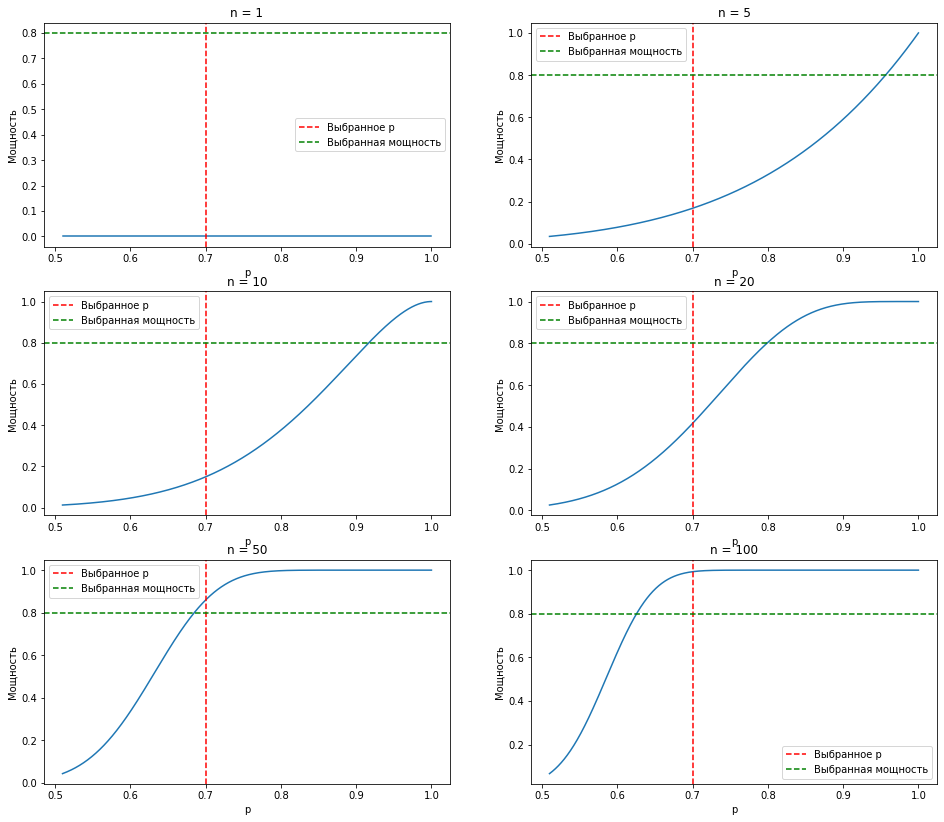

In [188]:
plt.figure(figsize=(16, 14))

for i, n in enumerate(nums):
    plt.subplot(len(nums)/2, 2, i + 1)
    c_alpha = sps.binom(n=n, p=0.5).ppf(1 - alpha)
    power = np.array(sps.binom(n=n, p=p).sf(c_alpha))
    
    plt.plot(p, power)
    plt.axvline(p_fix, ls='--', color='red', label="Выбранное p")
    plt.axhline(power_fix, ls='--', color='green', label="Выбранная мощность")
    plt.title('n = {}'.format(n))
    plt.xlabel('p')
    plt.ylabel('Мощность')
    plt.legend()

Как видим, оптимальный $n^* = 50$.

Для выбранного $n^*$ проведите эксперимент, аналогичный проведенным ранее экспериментам, сгенерировав выборки для следующих истинных значений $p$: 1). $1/2 < p < p^*$; 2). $p > p^*$.

In [190]:
make_dict_binom(50, 0.6, alpha)

t   p_value  reject
0  34  0.003300    True
1  23  0.664094   False
2  33  0.007673    True
3  30  0.059460   False
4  26  0.335906   False
5  28  0.161118   False
6  28  0.161118   False
7  28  0.161118   False
8  32  0.016420    True
9  28  0.161118   False

In [191]:
make_dict_binom(50, 0.85, alpha)

t       p_value  reject
0  42  1.049339e-07    True
1  38  4.510745e-05    True
2  38  4.510745e-05    True
3  38  4.510745e-05    True
4  44  2.104926e-09    True
5  44  2.104926e-09    True
6  46  1.854161e-11    True
7  42  1.049339e-07    True
8  40  2.807050e-06    True
9  41  5.817779e-07    True

**Вывод:** В ходе эксперимента подтвердилось, что отвержение гипотезы очень сильно зависит от размера выборки, и к размеру стоит подходить внимательно. При этом, в конце эксперимента мы заметили, что при выбранном нами фиксированном $p^*$ мы добились того, чего хотели: при бОльшем p мы отвергаем (что с практической точки зрения важно), при меньшем p - чаще не отвергаем.

### Задача 8

Вам нужно пронаблюдать эффект, который основные методы коррекции при множественной проверки гипотез оказывают на количественные характеристики критериев — FDR, FWER, мощность. В качестве примера рассматривается пороверка односторонних гипотез для компонент вектора средних $\theta$ трёхмерного нормального распределения с известной матрицей ковариаций $\Sigma$. 

**Описание эксперимента**

Дана выборка $X = (X_1, \ldots, X_n)$ из трёхмерного нормального распределения с неизвестным вектором средних ${\theta}$ и известной матрицей ковариаций ${\Sigma}$ и вектор ${\theta_0}$. Затем для каждой из компонент при помощи равномерно наиболее мощного критерия проверяется пара гипотез: $\mathsf{H}_j\colon\ \theta_j = \theta_j^0\ \ vs.\ \ \mathsf{H}'_j\colon\ \theta_j > \theta_j^0$. Уровень значимости для каждой из гипотез принимаем равным $\alpha = 0.05$.

Для простоты, в рамках эксперимента из каждой альтернативы будем рассматривать только одно значение $ \theta_j^1 \gg \theta_j^0 $, где ${\theta^{1}}$ — известный вектор. Для вектора средних ${\theta}$ рассматриваются все возможные комбинации: $ \theta_j = \theta_j^0\ \ vs.\ \ \theta_j = \theta_j^1$. В предположениях каждой из них генерируется выборка из $\mathcal{N}({\theta}, {\Sigma})$ и проверяются гипотезы. Эксперимент повторяется достаточное число раз, после чего вычисляются FDR, FWER и мощность критериев (доля правильно отвергнутых гипотез). Формально, вычисляются оценки данных величин.
Вначале эксперименты проводятся без МПГ-коррекции на каждом шаге, затем — с ней. Результаты сравниваются.

Всё вышеописанное повторяется для следующих матриц ковариаций:
1. Диагональная 
    $
    {\Sigma} = \begin{pmatrix} 
                           \alpha & 0 & 0\\ 
                           0 & \beta & 0\\ 
                           0 & 0 & \gamma 
                       \end{pmatrix}
    $;
2. Вырожденная $
    {\Sigma} = \begin{pmatrix} 
                           \alpha & \alpha & \alpha\\ 
                           \alpha & \alpha & \alpha\\ 
                           \alpha & \alpha & \alpha 
                       \end{pmatrix}
    $;
3. Произвольная ${\Sigma}$, не подходящая под условия 1 и 2.

**Реализация**

Вам предоставлен интерфейс для работы с классом `ExperimentHandler` из файла `mht.py`, который должен лежать в той же папке, что и ваш ipynb-файл. Вся работа с `ExperimentHandler` уже встроена в шаблон, *не меняйте ни класс, ни шаблон*. 

От вас требуется реализовать РНМК, вычисление FWER, FDR и мощности, а также три метода МПГ-коррекции — метод Бонферрони, метод Холма и метод Бенджамини-Иекутиели. Классы-заглушки вам выдаются, вам нужно только заполнить содержательные пропуски в их реализации. Необходимость в реализации методов МПГ-коррекции вызвана тем, что данные методы в statsmodels реализованы не оптимальное, и их использование в данной задаче загрузит ваш компьютер на несколько часов.

Для пущей вычислительной эффективности, каждый метод коррекции принимает на вход *матрицу* p-value размерностей `(число_экспериментов, число_гипотез)` и выдаёт тоже *матрицы*: булевую матрицу `reject`, которая указывает, какие именно гипотезы отвергаются, и числовую матрицу `adjusted`, содержащую скорректированные p-value. В данном случае число гипотез равно размерности многомерного нормального распределения, т.е. трём. Коррекция строк производится *независимо*, т.е. метод коррекции нужно применить к каждой строке, а результаты собрать в матрицу. Для вашего удобства, в шаблоне расставлены `assert`-ы, которые проверяют базовую адекватность ваших результатов. В силу нетривиальности векторизации этих методов (кроме Бонферрони), **разрешено использовать цикл по экспериментам**. Цикл по гипотезам тоже можно сделать, поскольку в данной задаче их всего три.

Код РНМК, на вход которому тоже подаётся матрица, должен быть полностью векторизован.

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
from mht import ExperimentHandler, AdjustmentMethodABC

#### 1. Реализация подсчёта FWER, FDR и мощности критериев

**a. FWER**

Напишите определение FWER и дополните данный шаблон с кодом.

<...>

In [ ]:
def compute_fwer(reject, alt_mask):
    """
    Аргументы:
    * reject: булева матрица результатов проверки гипотез,
        имеет размер (число_экспериментов, количество_гипотез).
        В позиции (k, j) записано True, если в эксперименте k 
        гипотеза H_j отвергается.
    * alt_mask: булев массив верности гипотез размера (количество_гипотез,).
        В позиции j записано True, если гипотеза H_j не верна.
        
    Возвращает число -- оценка fwer по данным экспериментам.
    """

    fwer = <...>

    assert np.isscalar(fwer)
    assert 0 <= fwer <= 1, "Посчитанное значение не в промежутке [0, 1]"
    return fwer

**b. FDR**

Напишите определение FWER и дополните данный шаблон с кодом.

<...>

In [ ]:
def compute_fdr(reject, alt_mask):
    """
    Аргументы:
    * reject: булева матрица результатов проверки гипотез,
        имеет размер (число_экспериментов, количество_гипотез).
        В позиции (k, j) записано True, если в эксперименте k 
        гипотеза H_j отвергается.
    * alt_mask: булев массив верности гипотез размера (количество_гипотез,).
        В позиции j записано True, если гипотеза H_j не верна.
        
    Возвращает число -- оценка fdr по данным экспериментам.
    """

    fdr = <...>

    assert np.isscalar(fdr)
    assert 0 <= fdr <= 1, "Посчитанное значение не в промежутке [0, 1]"
    return np.nan_to_num(fdr)

**c. Мощность**

Напишите определение мощности процедуры МПГ и дополните данный шаблон с кодом.

<...>

In [ ]:
def compute_power(reject, alt_mask):
    """
    Аргументы:
    * reject: булева матрица результатов проверки гипотез,
        имеет размер (число_экспериментов, количество_гипотез).
        В позиции (k, j) записано True, если в эксперименте k 
        гипотеза H_j отвергается.
    * alt_mask: булев массив верности гипотез размера (количество_гипотез,).
        В позиции j записано True, если гипотеза H_j не верна.
        
    Возвращает число -- оценка мощности по данным экспериментам.
    """

    # Если данные полностью согласуются с основными гипотезами, то 
    # мощность не определена, потому вместо неё возвращаем np.nan
    # (так полезно сделать, чтобы heatmap-ы нормально отрисовались)
    if ~np.any(alt_mask):
        return np.nan

    power = <...>

    assert np.isscalar(power)
    assert 0 <= power <= 1, "Посчитанное значение не в промежутке [0, 1]"
    return power

#### 2. Реализация методов МПГ-коррекции.  

Вам нужно реализовать три метода: метод Бонферрони, метод Холма и метод Бенджамини-Иекутиели.  
Напишите явно, какие величины (FDR, FWER) эти методы контролируют, а также приведите формулы пересчёта p-value и опишите процедуру, по которой определяется, какие из гипотез отвергнуть, а какие нет.  

*Если вы ошибётесь в формулах, все ваши последующие усилия будут напрасны, потому будьте внимательны.*

**a. Метод Бонферрони**

Краткое описание:

<...>

In [ ]:
class BonferroniAdjustment(AdjustmentMethodABC):
    def __init__(self, alpha):
        super().__init__(
            name="Метод Бонферрони", 
            alpha=alpha,
            controls_for="FWER"
        )
        
    def adjust(self, pvalues):
        """
        Аргументы:
        * pvalues: Матрица p-value, имеет размер 
            (число_экспериментов, количество_гипотез).
            В позиции (k, j) записано p-value критерия S_j для проверки 
            гипотезы H_j в эксперименте k.
            
        Возвращает:
        * reject: булева матрица результатов проверки гипотез,
            имеет размер (число_экспериментов, количество_гипотез).
            В позиции (k, j) записано True, если в эксперименте k 
            гипотеза H_j отвергается.
        * adjusted: Матрица скорректированных p-value, имеет размер 
            (число_экспериментов, количество_гипотез).
        """
        
        assert pvalues.ndim == 2,\
            "По условию задачи, adjust принимает матрицу "\
            "размерностей (число_экспериментов, количество_гипотез)"
        
        <...>
        
        assert (reject.shape == pvalues.shape \
                and adjusted.shape == pvalues.shape),\
            "Размерности матриц reject и adjusted "\
            "отличаются от размерностей входных данных"
        assert np.all((0 <= adjusted) & (adjusted <= 1)),\
            "Некоторые из скорректированных p-значений не лежат в [0, 1]"
        return reject, adjusted

**b. Метод Холма**

Краткое описание:

<...>

In [ ]:
class HolmAdjustment(AdjustmentMethodABC):
    def __init__(self, alpha):
        super().__init__(
            name="Метод Холма", 
            alpha=alpha,
            controls_for="FWER"
        )
    
    def adjust(self, pvalues):
        """
        Аргументы:
        * pvalues: Матрица p-value, имеет размер 
            (число_экспериментов, количество_гипотез).
            В позиции (k, j) записано p-value критерия S_j для проверки 
            гипотезы H_j в эксперименте k.
            
        Возвращает:
        * reject: булева матрица результатов проверки гипотез,
            имеет размер (число_экспериментов, количество_гипотез).
            В позиции (k, j) записано True, если в эксперименте k 
            гипотеза H_j отвергается.
        * adjusted: Матрица скорректированных p-value, имеет размер 
            (число_экспериментов, количество_гипотез).
        """
        
        assert pvalues.ndim == 2,\
            "По условию задачи, adjust принимает матрицу "\
            "размерностей (число_экспериментов, количество_гипотез)"
        
        <...>
        
        assert (reject.shape == pvalues.shape \
                and adjusted.shape == pvalues.shape),\
            "Размерности матриц reject и adjusted "\
            "отличаются от размерностей входных данных"
        assert np.all((0 <= adjusted) & (adjusted <= 1)),\
            "Некоторые из скорректированных p-значений не лежат в [0, 1]"
        return reject, adjusted

**c. Метод Бенджамини-Иекутиели**

Краткое описание:

<...>

In [ ]:
  class BenjaminiYekutieliAdjustment(AdjustmentMethodABC):
    def __init__(self, alpha):
        super().__init__(
            name="Метод Бенджамини-Иекутиели", 
            alpha=alpha,
            controls_for="FDR"
        )
    
    def adjust(self, pvalues):
        """
        Аргументы:
        * pvalues: Матрица p-value, имеет размер 
            (число_экспериментов, количество_гипотез).
            В позиции (k, j) записано p-value критерия S_j для проверки 
            гипотезы H_j в эксперименте k.
            
        Возвращает:
        * reject: булева матрица результатов проверки гипотез,
            имеет размер (число_экспериментов, количество_гипотез).
            В позиции (k, j) записано True, если в эксперименте k 
            гипотеза H_j отвергается.
        * adjusted: Матрица скорректированных p-value, имеет размер 
            (число_экспериментов, количество_гипотез).
        """
        
        assert pvalues.ndim == 2,\
            "По условию задачи, adjust принимает матрицу "\
            "размерностей (число_экспериментов, количество_гипотез)"
        
        <...>
        
        assert (reject.shape == pvalues.shape \
                and adjusted.shape == pvalues.shape),\
            "Размерности матриц reject и adjusted "\
            "отличаются от размерностей входных данных"
        assert np.all((0 <= adjusted) & (adjusted <= 1)),\
            "Некоторые из скорректированных p-значений не лежат в [0, 1]"
        return reject, adjusted

#### 4. Реализация РНМК 

Выпишите формулу РНМК для гипотезы $\mathsf{H}_0\colon\ \theta = \theta_0\ \ vs.\ \ \mathsf{H}_1\colon\ \theta > \theta_0$ для $\mathcal{N}(\theta, \sigma^2)$ с известной дисперсией (одномерный случай). Реализуйте его в коде.

<...>

In [ ]:
def criterion(samples, theta_0, Sigma):
    """
    Векторная реализация равномерно наиболее мощного критерия 
    для правосторонней гипотезы из условия.
    
    Аргументы:
    * samples: Матрица выборок размера 
        (число_экспериментов, размер_выборок, размерность_пространства)
    * theta_0: Вектор средних, соответствующий основным гипотезам. 
        Размер (размерность_пространства,)
    * Sigma: Матрица ковариаций компонент вектора. 
        Размер (размерность_пространства, размерность_пространства)
    
    Возвращает:
    * pvalues: Матрица p-value, имеет размер 
        (число_экспериментов, количество_гипотез).
        В позиции (k, j) записано p-value критерия S_j для проверки 
        гипотезы H_j в эксперименте k.
    """
    assert samples.ndim == 3, "На вход должен подаваться 3-мерный тензор"
    n_runs, sample_size, n_hypotheses = samples.shape
    
    <...>
    
    assert pvalues.shape == (n_runs, n_hypotheses),\
        "Некорректная форма матрицы p-значений."\
        f"Должно быть {(n_runs, n_hypotheses)}, a вместо этого {pvalues.shape}"
    return pvalues

#### 5. Задание общих параметров

Установим значения величин ${\theta_0}, {\theta_1}, {\Sigma}$, а также уровня значимости, числа запусков эксперимента и размера выборки в каждом из них.  
Эти параметры остаются неизменными от итерации к итерации. Для отладки выставляйте `n_runs = 100` или меньше.

In [ ]:
theta_list = [
    <вектор \theta_0 размера 3>,
    <вектор \theta_1 размера 3>
]
sample_size = 4  # размер выборки на каждой итерации
n_runs = int(1e6)  # число экспериментов для каждой из 8 конфигураций
alpha = 0.05  # уровень значимости
random_seed = 42  # random_state (для воспроизводимости)

# методы коррекции p-значений (не менять)
correction_methods = [
    BonferroniAdjustment(alpha=alpha),
    HolmAdjustment(alpha=alpha),
    BenjaminiYekutieliAdjustment(alpha=alpha)
]
method_names = ["bonferroni", "holm", "fdr_by"]
experiment_results = {}

#### 6. Проверка корректности

Убедимся в корректности нашей реализации, сравнив с эталонным решением из библиотеки `statsmodels`.  

*Не меняйте код этой ячейки. Прохождение тестов — необходимое условие того, что ваша работа будет засчитана.*

In [ ]:
testing_iters = 100
runs_per_test = 10
for i, method in tqdm_notebook(enumerate(correction_methods), 
                               "перебор методов"):
    print(f"{method.name}. Проверка корректности.")
    for _ in tqdm_notebook(range(testing_iters), "итерации проверки"):
        pmx = np.random.rand(runs_per_test, 3)
        our_reject, our_adjusted = method(pmx)
        true_reject = []
        true_adjusted = []
        for j in range(runs_per_test):
            result = multipletests(
                pmx[j, :], 
                method=method_names[i]
            )
            true_reject.append(result[0])
            true_adjusted.append(result[1])
        true_reject = np.vstack(true_reject)
        true_adjusted = np.vstack(true_adjusted)
        assert np.allclose(our_adjusted, true_adjusted),\
            f"{method.name} выдаёт не те p-значения после коррекции"
        assert np.all(our_reject == true_reject),\
                f"{method.name} отвергает не те гипотезы" 

#### 7. Эксперименты

**a.** Диагональная матрица $\mathbf{\Sigma}$

In [ ]:
Sigma = <определите матрицу 3 на 3>
experiment = ExperimentHandler(
    theta_list=theta_list, 
    Sigma=Sigma,
    cov_mx_description="1. Диагональная матрица ковариаций",
    alpha=alpha,
    n_runs=n_runs,
    sample_size=sample_size, 
    random_seed=random_seed,
    correction_methods=correction_methods,
    criterion=criterion,
    compute_fwer=compute_fwer,
    compute_fdr=compute_fdr,
    compute_power=compute_power
)
experiment_results["1"] = experiment.run()

**b.** Вырожденная матрица $\mathbf{\Sigma}$

In [ ]:
Sigma = <определите матрицу 3 на 3>
experiment = ExperimentHandler(
    theta_list=theta_list, 
    Sigma=Sigma,
    cov_mx_description="2. Вырожденная матрица",
    alpha=alpha,
    n_runs=n_runs,
    sample_size=sample_size, 
    random_seed=random_seed,
    correction_methods=correction_methods,
    criterion=criterion,
    compute_fwer=compute_fwer,
    compute_fdr=compute_fdr,
    compute_power=compute_power
)
experiment_results["2"] = experiment.run()

**с.** Произвольная матрица $\mathbf{\Sigma}$

In [ ]:
Sigma = <определите матрицу 3 на 3>

assert (np.all(Sigma == Sigma.T) 
        and np.all(np.linalg.eigvals(Sigma) >= 0)),\
    "Это не матрица ковариаций."

experiment = ExperimentHandler(
    theta_list=theta_list, 
    Sigma=Sigma,
    cov_mx_description="3. Произвольная матрица ковариаций",
    alpha=alpha,
    n_runs=n_runs,
    sample_size=sample_size, 
    random_seed=random_seed,
    correction_methods=correction_methods,
    criterion=criterion,
    compute_fwer=compute_fwer,
    compute_fdr=compute_fdr,
    compute_power=compute_power
)
experiment_results["3"] = experiment.run()

#### 8. Вывод

Опишите, какие свойства методов МПГ-коррекции вы пронаблюдали. Обоснуйте, почему их обязательно нужно применять. Поясните, что будет, если этого не делать.

<...>